In [1]:
import time
import os
import math
import numpy as np
import cv2
import pandas as pd
import pyautogui as pa
import shutil
import imageio
from PIL import Image, ImageDraw

from lib.auto_GUI.auto_GUI_base import AutoGUIBase
from lib.auto_GUI.auto_DAT import AutoDAT
from lib.auto_GUI.auto_PhotoZ import AutoPhotoZ
from lib.analysis.laminar_dist import *
from lib.file.TIF import *
from lib.analysis.align import ImageAlign
from lib.utilities import *

In [2]:
""" 
    Given an SNR cutoff, find the area (# pixels) that is above cutoff.
        Input: ZDA files (need to export every SNR frame from start frame to end frame)
        Output:
            A(t) in a data file and a plot
            Movies of the change of this area in frames, two-color frames
"""
data_dir = "C:/Users/jjudge3/Desktop/Data/mm_full_pipeline_targets/"
start_frame = 94
movie_length = 27
snr_cutoff = 5.0

disable_photoZ_interact = False
initialize_photoZ = True
clean_scratch_files = False  # clean up SNR maps
replace_existing_frame_dats = False

In [3]:
# set up PhotoZ (open it manually)
aPhz = AutoPhotoZ(data_dir=data_dir)
if initialize_photoZ and not disable_photoZ_interact:
    aPhz.prepare_photoZ()
if not disable_photoZ_interact:
    aPhz.click_normalize_2_array_max()
pa.alert("Please disable trace overlay and maximize PhotoZ before continuing.")

'OK'

In [4]:
snr_dict = {}

for subdir, dirs, files in os.walk(data_dir):
    if 'notUsable' in subdir:
        continue
    if 'mm_hidden' in subdir:
        continue
    if 'converted_zda' in subdir:
        continue

    for zda_file in files:
        if not zda_file.endswith('.zda'):
            continue

        rec_id = zda_file.split('.')[0]
        print(rec_id)
        # movie dir
        movie_dir = subdir + "/responseArea" + rec_id + "/"

        slic, loc, rec = [int(x) for x in rec_id.split("_")]
        print(slic, loc, rec)
        try:
            os.makedirs(movie_dir)
        except Exception as e:
            pass

        if not disable_photoZ_interact:
            aPhz = AutoPhotoZ(data_dir=subdir)


            need_to_open_zda = False
            for frame in range(start_frame, start_frame + movie_length):
                f = aPhz.pad_zeros(slic) + "_" + aPhz.pad_zeros(loc) + "_" + aPhz.pad_zeros(rec) + ".dat"
                f = subdir + "/SNR_" + rec_id + "_frame" + str(frame)+"_" + f
                if not os.path.exists(f):
                    need_to_open_zda = True

            need_to_open_zda = (need_to_open_zda or replace_existing_frame_dats)
            if need_to_open_zda:
                # open the PhotoZ file
                aPhz.select_PhotoZ()

                print("\n\nOpening", zda_file)
                aPhz.open_zda_file(subdir + "/" + zda_file)

                # set measure window width to 1
                aPhz.set_measure_window(None, 1)
            for frame in range(start_frame, start_frame + movie_length):
                f = aPhz.pad_zeros(slic) + "_" + aPhz.pad_zeros(loc) + "_" + aPhz.pad_zeros(rec) + ".dat"
                f = subdir + "/SNR_" + rec_id + "_frame" + str(frame)+"_" + f
                if not os.path.exists(f):
                    aPhz.set_measure_window(frame, None)
                    aPhz.select_array_tab()
                snr_filename = AutoDAT(datadir=subdir,
                        file_prefix="SNR_" + rec_id + "_frame" + str(frame)+"_").save_background(slic, 
                                                                                                 loc, 
                                                                                                 rec,
                                                                                                 overwrite_existing=replace_existing_frame_dats)
                if subdir not in snr_dict:
                    snr_dict[subdir] = {}
                if rec_id not in snr_dict[subdir]:
                    snr_dict[subdir][rec_id] = {}
                if frame not in snr_dict[subdir][rec_id]:
                    snr_dict[subdir][rec_id][frame] = { 'filename': snr_filename }

02_01_01
2 1 1


Opening 02_01_01.zda
02_01_03
2 1 3


Opening 02_01_03.zda
02_02_02
2 2 2


Opening 02_02_02.zda
03_01_01
3 1 1


Opening 03_01_01.zda
03_02_01
3 2 1


Opening 03_02_01.zda
03_02_02
3 2 2


Opening 03_02_02.zda
03_02_12
3 2 12


Opening 03_02_12.zda
06_01_01
6 1 1


Opening 06_01_01.zda
06_01_03
6 1 3


Opening 06_01_03.zda
06_01_06
6 1 6


Opening 06_01_06.zda
01_01_07
1 1 7


Opening 01_01_07.zda
01_02_05
1 2 5


Opening 01_02_05.zda
01_03_03
1 3 3


Opening 01_03_03.zda
01_03_04
1 3 4


Opening 01_03_04.zda
01_04_02
1 4 2


Opening 01_04_02.zda
01_05_05
1 5 5


Opening 01_05_05.zda
02_01_02
2 1 2


Opening 02_01_02.zda
02_01_04
2 1 4


Opening 02_01_04.zda
02_02_02
2 2 2


Opening 02_02_02.zda
02_03_05
2 3 5


Opening 02_03_05.zda
02_03_08
2 3 8


Opening 02_03_08.zda
02_01_01
2 1 1


Opening 02_01_01.zda
02_01_04
2 1 4


Opening 02_01_04.zda
02_01_06
2 1 6


Opening 02_01_06.zda
02_02_03
2 2 3


Opening 02_02_03.zda
02_03_02
2 3 2


Opening 02_03_02.zda
02_04_02
2 

02_01_01
2 1 1
C:/Users/jjudge3/Desktop/Data/mm_full_pipeline_targets/02-28-23\selected_zda\analysis02_01_01


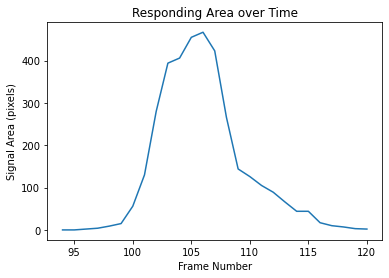

CREATED MOVIE: 02_01_01area_movie.gif
02_01_03
2 1 3
C:/Users/jjudge3/Desktop/Data/mm_full_pipeline_targets/02-28-23\selected_zda\analysis02_01_03


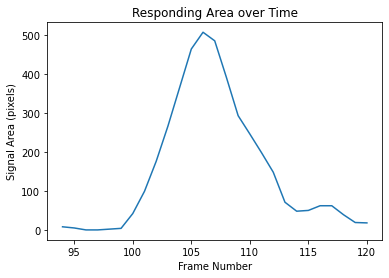

CREATED MOVIE: 02_01_03area_movie.gif
02_02_02
2 2 2
C:/Users/jjudge3/Desktop/Data/mm_full_pipeline_targets/02-28-23\selected_zda\analysis02_02_02


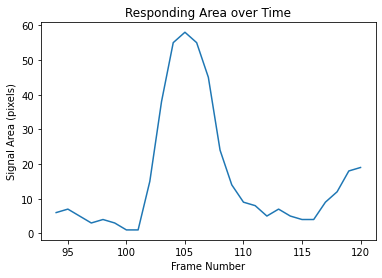

CREATED MOVIE: 02_02_02area_movie.gif
03_01_01
3 1 1
C:/Users/jjudge3/Desktop/Data/mm_full_pipeline_targets/02-28-23\selected_zda\analysis03_01_01


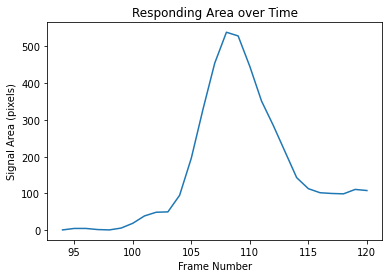

CREATED MOVIE: 03_01_01area_movie.gif
03_02_01
3 2 1
C:/Users/jjudge3/Desktop/Data/mm_full_pipeline_targets/02-28-23\selected_zda\analysis03_02_01


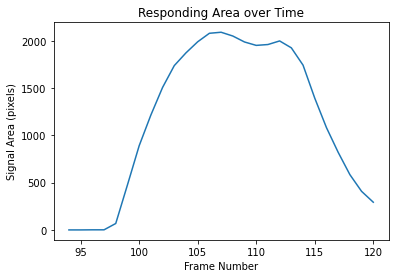

CREATED MOVIE: 03_02_01area_movie.gif
03_02_02
3 2 2
C:/Users/jjudge3/Desktop/Data/mm_full_pipeline_targets/02-28-23\selected_zda\analysis03_02_02


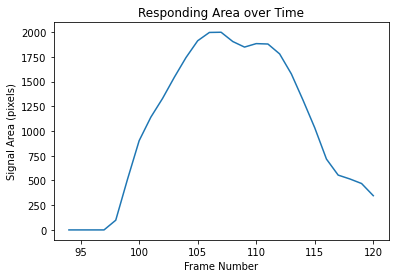

CREATED MOVIE: 03_02_02area_movie.gif
03_02_12
3 2 12
C:/Users/jjudge3/Desktop/Data/mm_full_pipeline_targets/02-28-23\selected_zda\analysis03_02_12


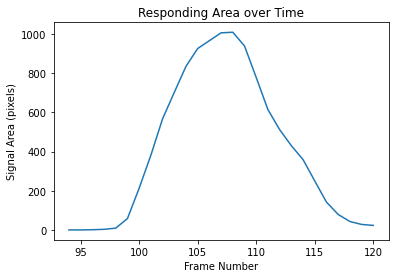

CREATED MOVIE: 03_02_12area_movie.gif
06_01_01
6 1 1
C:/Users/jjudge3/Desktop/Data/mm_full_pipeline_targets/02-28-23\selected_zda\analysis06_01_01


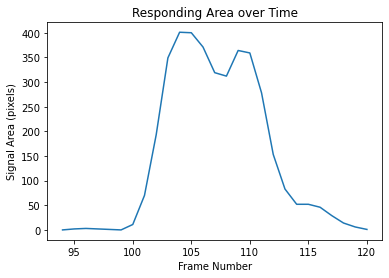

CREATED MOVIE: 06_01_01area_movie.gif
06_01_03
6 1 3
C:/Users/jjudge3/Desktop/Data/mm_full_pipeline_targets/02-28-23\selected_zda\analysis06_01_03


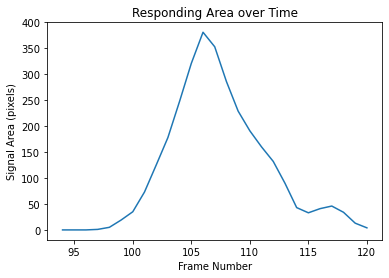

CREATED MOVIE: 06_01_03area_movie.gif
06_01_06
6 1 6
C:/Users/jjudge3/Desktop/Data/mm_full_pipeline_targets/02-28-23\selected_zda\analysis06_01_06


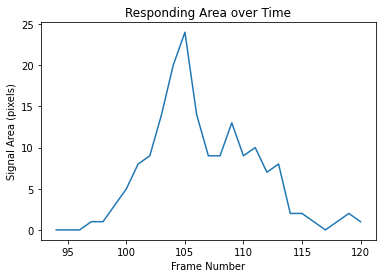

CREATED MOVIE: 06_01_06area_movie.gif
01_01_07
1 1 7
C:/Users/jjudge3/Desktop/Data/mm_full_pipeline_targets/03-07-23\selected_zda\analysis01_01_07


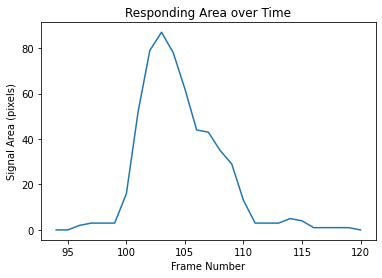

CREATED MOVIE: 01_01_07area_movie.gif
01_02_05
1 2 5
C:/Users/jjudge3/Desktop/Data/mm_full_pipeline_targets/03-07-23\selected_zda\analysis01_02_05


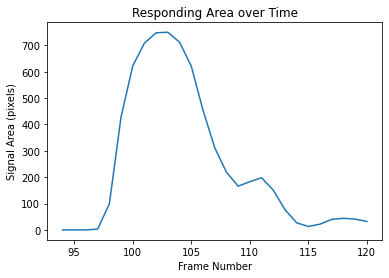

CREATED MOVIE: 01_02_05area_movie.gif
01_03_03
1 3 3
C:/Users/jjudge3/Desktop/Data/mm_full_pipeline_targets/03-07-23\selected_zda\analysis01_03_03


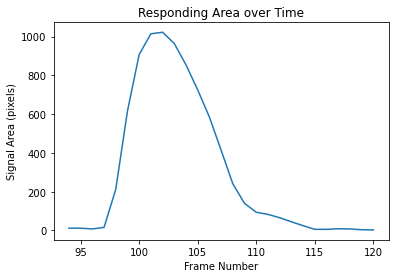

CREATED MOVIE: 01_03_03area_movie.gif
01_03_04
1 3 4
C:/Users/jjudge3/Desktop/Data/mm_full_pipeline_targets/03-07-23\selected_zda\analysis01_03_04


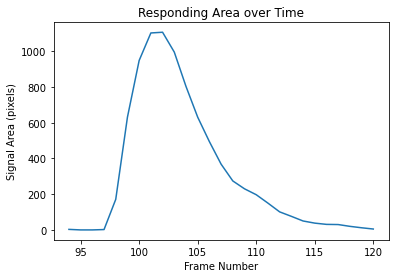

CREATED MOVIE: 01_03_04area_movie.gif
01_04_02
1 4 2
C:/Users/jjudge3/Desktop/Data/mm_full_pipeline_targets/03-07-23\selected_zda\analysis01_04_02


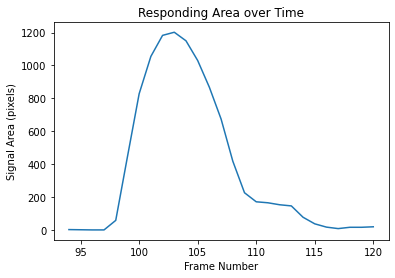

CREATED MOVIE: 01_04_02area_movie.gif
01_05_05
1 5 5
C:/Users/jjudge3/Desktop/Data/mm_full_pipeline_targets/03-07-23\selected_zda\analysis01_05_05


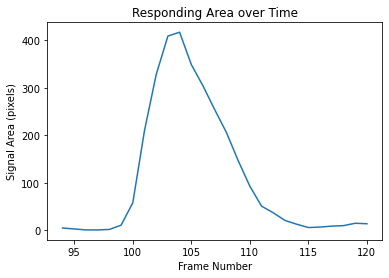

CREATED MOVIE: 01_05_05area_movie.gif
02_01_02
2 1 2
C:/Users/jjudge3/Desktop/Data/mm_full_pipeline_targets/03-07-23\selected_zda\analysis02_01_02


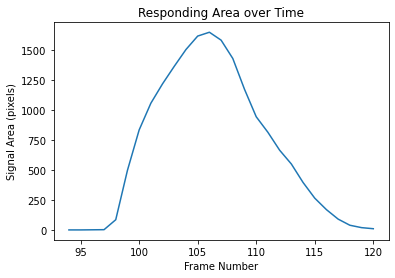

CREATED MOVIE: 02_01_02area_movie.gif
02_01_04
2 1 4
C:/Users/jjudge3/Desktop/Data/mm_full_pipeline_targets/03-07-23\selected_zda\analysis02_01_04


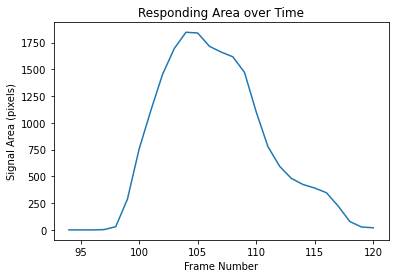

CREATED MOVIE: 02_01_04area_movie.gif
02_02_02
2 2 2
C:/Users/jjudge3/Desktop/Data/mm_full_pipeline_targets/03-07-23\selected_zda\analysis02_02_02


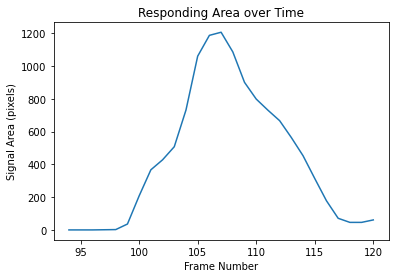

CREATED MOVIE: 02_02_02area_movie.gif
02_03_05
2 3 5
C:/Users/jjudge3/Desktop/Data/mm_full_pipeline_targets/03-07-23\selected_zda\analysis02_03_05


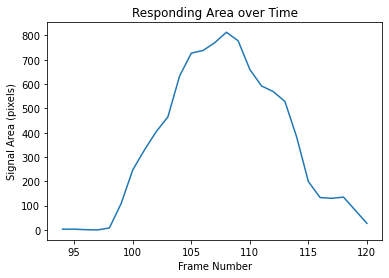

CREATED MOVIE: 02_03_05area_movie.gif
02_03_08
2 3 8
C:/Users/jjudge3/Desktop/Data/mm_full_pipeline_targets/03-07-23\selected_zda\analysis02_03_08


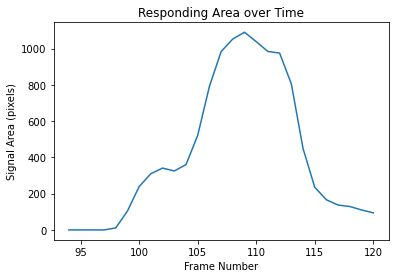

CREATED MOVIE: 02_03_08area_movie.gif
02_01_01
2 1 1
C:/Users/jjudge3/Desktop/Data/mm_full_pipeline_targets/03-15-23\selected_zda\analysis02_01_01


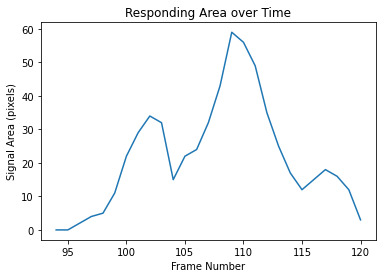

CREATED MOVIE: 02_01_01area_movie.gif
02_01_04
2 1 4
C:/Users/jjudge3/Desktop/Data/mm_full_pipeline_targets/03-15-23\selected_zda\analysis02_01_04


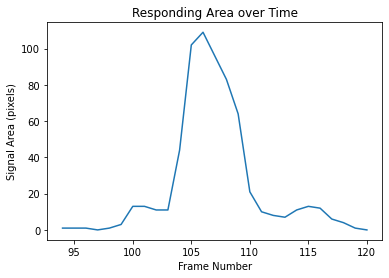

CREATED MOVIE: 02_01_04area_movie.gif
02_01_06
2 1 6
C:/Users/jjudge3/Desktop/Data/mm_full_pipeline_targets/03-15-23\selected_zda\analysis02_01_06


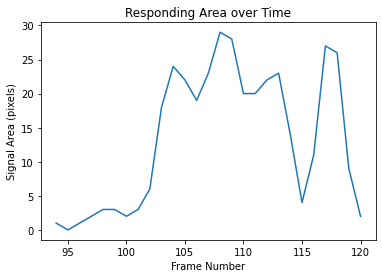

CREATED MOVIE: 02_01_06area_movie.gif
02_02_03
2 2 3
C:/Users/jjudge3/Desktop/Data/mm_full_pipeline_targets/03-15-23\selected_zda\analysis02_02_03


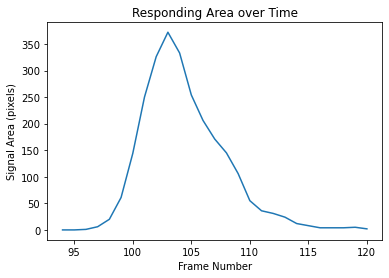

CREATED MOVIE: 02_02_03area_movie.gif
02_03_02
2 3 2
C:/Users/jjudge3/Desktop/Data/mm_full_pipeline_targets/03-15-23\selected_zda\analysis02_03_02


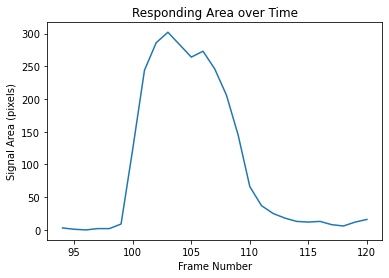

CREATED MOVIE: 02_03_02area_movie.gif
02_04_02
2 4 2
C:/Users/jjudge3/Desktop/Data/mm_full_pipeline_targets/03-15-23\selected_zda\analysis02_04_02


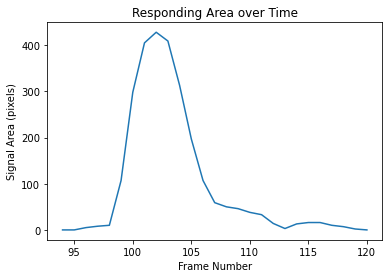

CREATED MOVIE: 02_04_02area_movie.gif
02_06_01
2 6 1
C:/Users/jjudge3/Desktop/Data/mm_full_pipeline_targets/03-15-23\selected_zda\analysis02_06_01


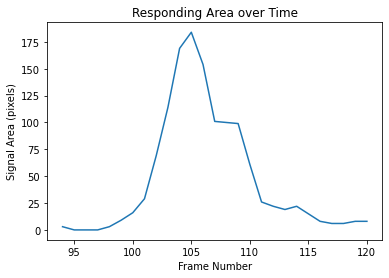

CREATED MOVIE: 02_06_01area_movie.gif
02_06_05
2 6 5
C:/Users/jjudge3/Desktop/Data/mm_full_pipeline_targets/03-15-23\selected_zda\analysis02_06_05


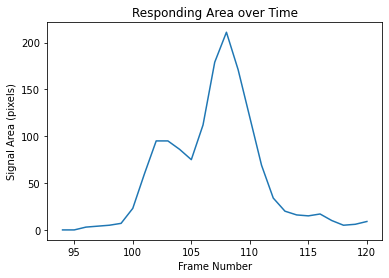

CREATED MOVIE: 02_06_05area_movie.gif
02_06_06
2 6 6
C:/Users/jjudge3/Desktop/Data/mm_full_pipeline_targets/03-15-23\selected_zda\analysis02_06_06


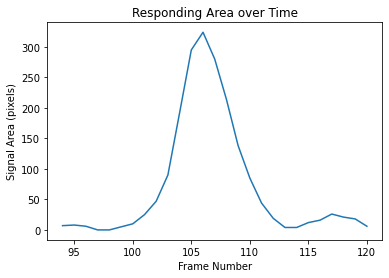

CREATED MOVIE: 02_06_06area_movie.gif
03_01_03
3 1 3
C:/Users/jjudge3/Desktop/Data/mm_full_pipeline_targets/03-15-23\selected_zda\analysis03_01_03


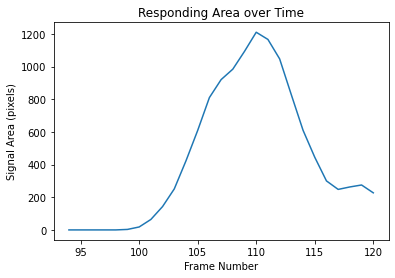

CREATED MOVIE: 03_01_03area_movie.gif
03_01_05
3 1 5
C:/Users/jjudge3/Desktop/Data/mm_full_pipeline_targets/03-15-23\selected_zda\analysis03_01_05


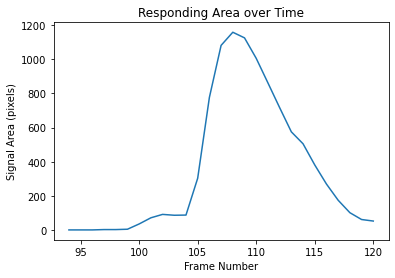

CREATED MOVIE: 03_01_05area_movie.gif
03_01_08
3 1 8
C:/Users/jjudge3/Desktop/Data/mm_full_pipeline_targets/03-15-23\selected_zda\analysis03_01_08


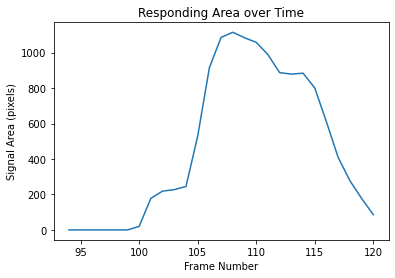

CREATED MOVIE: 03_01_08area_movie.gif
03_04_02
3 4 2
C:/Users/jjudge3/Desktop/Data/mm_full_pipeline_targets/03-15-23\selected_zda\analysis03_04_02


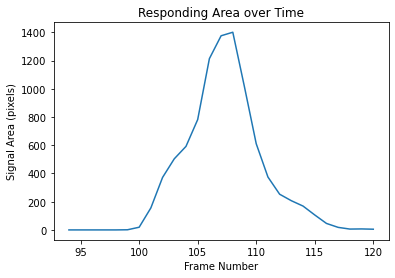

CREATED MOVIE: 03_04_02area_movie.gif
03_04_06
3 4 6
C:/Users/jjudge3/Desktop/Data/mm_full_pipeline_targets/03-15-23\selected_zda\analysis03_04_06


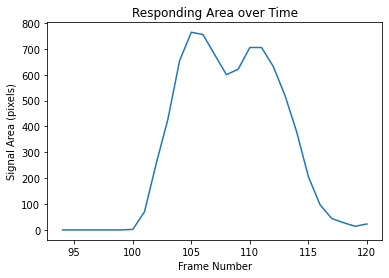

CREATED MOVIE: 03_04_06area_movie.gif


In [5]:
for subdir, dirs, files in os.walk(data_dir):
    if 'notUsable' in subdir:
        continue
    if 'mm_hidden' in subdir:
        continue
    if 'converted_zda' in subdir:
        continue
    
    for zda_file in files:
        if not zda_file.endswith('.zda'):
            continue

        rec_id = zda_file.split('.')[0]
        print(rec_id)
        # movie dir
        movie_dir = subdir + "/responseArea" + rec_id + "/"
        
        slic, loc, rec = [int(x) for x in rec_id.split("_")]
        print(slic, loc, rec)
        
        snr_frames = []
        areas_over_time = []
        images = []
        for frame in range(start_frame, start_frame + movie_length):
            snr_filename = snr_dict[subdir][rec_id][frame]['filename']

            snr_frame = np.loadtxt(snr_filename,
                         delimiter='\t',
                         usecols=(1,))
            width = int(np.sqrt(snr_frame.shape[0]))
            snr_frame = snr_frame.reshape((width, width))
            snr_frame = (snr_frame > snr_cutoff)
            area = np.sum(snr_frame)
            snr_frames.append(snr_frame)
            areas_over_time.append(area)
            # print(snr_frame, area)
            plt.clf()
            plt.imshow(snr_frame)
            fn_image = movie_dir + str(frame) + ".png"
            plt.savefig(fn_image)
            images.append(imageio.imread(fn_image))
            
        # plot A(t)
        print(subdir)
        plt.clf()
        plt.plot([i for i in range(start_frame, start_frame + movie_length)], 
                 areas_over_time)
        plt.xlabel("Frame Number")
        plt.ylabel("Signal Area (pixels)")
        plt.title("Responding Area over Time")
        plt.savefig(movie_dir + "area.png")
        plt.show()
        
        # Make boolean signal movie (animated gif)
        created_movie = False
        try:
            imageio.mimsave(movie_dir + 'area_movie.gif', images)
            print("CREATED MOVIE:", rec_id + 'area_movie.gif')
            created_movie = True
            if clean_scratch_files:
                for img_file in img_filenames:
                    os.remove(img_file)
        except Exception as e:
            if not created_movie:
                print("Not creating movie for " + rec_id)
            print(e)
        